# model_grid

En el "model_grid", se entrena una red neuronal por medio de __Transfer Learning__.

Se aplica un "grid-search" para buscar el modelo más óptimo de los definidos previamente.

Por falta de recurso computacional no se ha podido ejectuar el entrenamiento del modelo.

In [17]:
# Funciones
# ================================================================================================================================
import os, sys
sys.path.insert(1, r'C:\Users\gonza\OneDrive\Escritorio\Bootcamp_DS\Alumno\ds_thebridge_1_22\3-Machine_Learning\Entregas\utils')
from funciones import procesamiento_de_datos_X, procesamiento_de_datos_y, define_x_y, contar_imagenes
from funciones import plot_cm, metricas, plot_roc_curve, definir_modelo

# Tratamiento de datos
# ==============================================================================
import os
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Tratamiento de imágenes
# ==============================================================================
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import regularizers  
from keras import layers
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Preprocesado y modelado
# ================================================================================================================
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# 1. Procesamiento de datos
==================================================================================================

In [2]:
path_train = '../data/processed/train'
path_val = '../data/processed/val'
path_test = '../data/processed/test'
tipos = os.listdir(path_train)

In [3]:
# Definimos variables
X_train, y_train = define_x_y(path_train)
X_val, y_val = define_x_y(path_val)
X_test, y_test = define_x_y(path_test)

In [4]:
# Procesamiento de datos
X_train, X_val, X_test = procesamiento_de_datos_X(X_train, X_val, X_test)
y_train, y_val, y_test = procesamiento_de_datos_y(y_train, y_val, y_test)

### Definición de los pesos

In [8]:
summary_y_train = contar_imagenes(path_train, tipos)

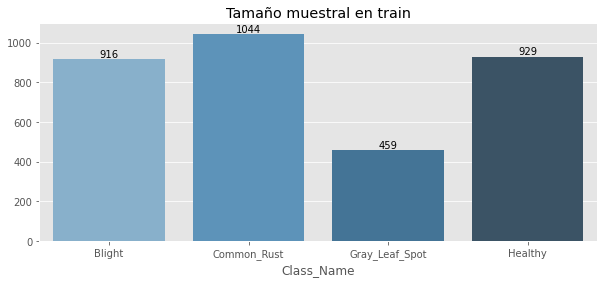

In [11]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=summary_y_train.iloc[:,0], y=summary_y_train.iloc[:,1], palette='Blues_d')
plt.title('Tamaño muestral en train')
plt.ylabel('', fontsize=18)
ax.bar_label(ax.containers[0]);

Vemos que el target está desbalanceado ligeramente

Para lograr un modelo que genelarice bien, __es fundamental compensar este desequilibrio__. De lo contrario, un modelo de ML tenderá a ignorar las muestras minoritarias, y por tanto tener un rendimiento menor cuando haya que etiquetarlas.

En este caso, los datos están desproporcionados ligeramente, especialemnte contamos con una minoría clara: 'Gray-Leaf_Spot'. Aplicaremos pesos si mejora el rendimiento de nuestro modelo.

In [13]:
summary_y_train['actual_weight'] = summary_y_train['No of Images'] / summary_y_train['No of Images'].sum()
summary_y_train['weight'] = 1 / (summary_y_train['No of Images'] / summary_y_train['No of Images'].max())

summary_y_train

,Class_Name,No of Images,actual_weight,weight
0,Blight,916,0.273596,1.139738
1,Common_Rust,1044,0.311828,1.000000
2,Gray_Leaf_Spot,459,0.137097,2.274510
3,Healthy,929,0.277479,1.123789


In [14]:
# {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
class_weights = {i : summary_y_train['weight'][i] for i in range(len(summary_y_train))}  
class_weights

{0: 1.1397379912663756, 1: 1.0, 2: 2.2745098039215685, 3: 1.123789020452099}

# 2. Definición del modelo
==================================================================================================

## Transfer Learning

Una red neuronal permite añadir varias capas de aprendizaje de forma secuencial. Se puede comenzar desde cero, de tal forma que el modelo parta de una base en blanco, o se le puede dar otra red neuronal de entrada para que entrene y aprenda partiendo de un conocimiento previo.

Vamos a utilizar como capa de entrada una red neuronal ya entrenada previamente por expertos, disponibles al público en __[TensorFlow Hub](https://tfhub.dev/)__.

In [17]:
# Escogemos el modelo base, sobre diagnóstico de plantas están disponibles los siguientes:

modelos_google_cropnet = {
    'cropnet_cassava': 'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat': 'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet': 'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224': 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

## Modelo secuencial

El modelo __Sequential__ es una forma eficaz para construir un modelo en _Keras_, una interfaz para la librería _TensorFlow_. A este modelo se le agrega cada capa, capa por capa, mediante la función 'add()'.

Para componer el modelo, indicaremostres campos:

- __Optimizador__: Utilizamores el optimizador __Adam__, ya que según Kingma et al., 2014 este método es _"computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters"._
 
- __Función de pérdidas__: Utilizaremos el __'Sparse categorical cross entropy'__, muy común para los modelos de clasificación multi-clase. Las funciones de pérdidas (loss functions) muestran cuánto se desvían las estimaciones de su valor real.

- __Métrica__: Utilizamos la métrica __Recall__, la cual muestra el porcentaje de positivos reales que se clasificaron correctamente. Como tratamos de diagnosticar qué plantas de maíz están enfermas, entonces, es de vital importancia identificar bien a todas las que sí que lo estén, y reducir el error de que no queden clasificadas como enfermas. Como segunda métrica decisiva, utilizaremos el F2 score. Como las métricas se han eliminado de keras (2.0 version), utilizaremos 'accuracy'.

## Fine-tuning

Vamos a hacer un _gridsearch_ para escoger el modelo que mejor métricas tenga

In [19]:
# Al ser un modelo de clasificación, utilizamos un KerasClassifier wrapper
keras_estimator = KerasClassifier(build_fn=definir_modelo, verbose=1, batch_size=128, epochs=11)

# Definimos un pipeline
pipe_keras = Pipeline([("kc", keras_estimator)])

# Definimos los distintos hiperparámetros en los que iteraremos
param_grid = {
    'kc__base_model': [modelos_google_cropnet['cropnet_cassava'], modelos_google_cropnet['cropnet_concat'], 
                    modelos_google_cropnet['cropnet_imagenet'], modelos_google_cropnet['mobilenet_v3_large_100_224']],
    'kc__epochs': [5, 11],
    'kc__batch_size':[32, 128],
    'kc__class_weight' : [None, class_weights]
    }

# Gridsearch
grid = GridSearchCV(estimator=pipe_keras,  
                    n_jobs=-1, 
                    verbose=2,
                    return_train_score=True,
                    cv=5,  #cross validation (n_splits=5, shuffle=True)
                    param_grid=param_grid,
                    )

# 3. Entrenamiento del modelo
==================================================================================================

In [20]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


### Falta de resultados

Por falta de recurso computacional, este último paso no se puede llevar a cabo. No obstante, ya se ha desglosado en el resto de notebooks modelo por modelo, sin iterar mediante un grid search.